In [22]:
import os
import pickle
from glob import glob
import torch
import torch.nn as nn
import torch.optim as optim
import torch.jit
from tqdm.notebook import tqdm
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
import numpy as np

from support import *

In [23]:
results = [pickle.load(open(f, 'rb')) for f in glob('./result-50p/*.pkl')]
results = [item for sublist in results for item in sublist]

In [24]:
np.max([r.result for r in results]), np.min([r.result for r in results])

(44963, 20)

In [25]:
broad_words = set([word for r in results for word in r.broad_words])
narrow_words = set([word for r in results for word in r.narrow_words])
broad_words_toi = {word: i for i, word in enumerate(broad_words)}
narrow_words_toi = {word: i for i, word in enumerate(narrow_words)}
broad_words_ito = {i: word for word, i in broad_words_toi.items()}
narrow_words_ito = {i: word for word, i in narrow_words_toi.items()}
pickle.dump(broad_words_toi, open('broad_words_toi.pkl', 'wb'))
pickle.dump(narrow_words_toi, open('narrow_words_toi.pkl', 'wb'))

In [26]:
samples = []
for r in results:
    broad = torch.zeros(len(broad_words))
    narrow = torch.zeros(len(narrow_words))
    for (word, sel) in zip(r.broad_words, r.broad_sel):
        broad[broad_words_toi[word]] = 1 if sel else -1
    for (word, sel) in zip(r.narrow_words, r.narrow_sel):
        narrow[narrow_words_toi[word]] = 1 if sel else -1
    samples.append((
        broad.to(torch.float),
        narrow.to(torch.float), 
        torch.tensor([r.result]).to(torch.float)
    ))
torch.save(samples, 'samples.pt')

In [27]:
samples = torch.load('samples.pt')
dataloader = DataLoader(samples, batch_size=128, shuffle=True)
samples.__len__(), len(broad_words), len(narrow_words)

(14472, 127, 608)

In [28]:
class Model(nn.Module):
    def __init__(self, n_broad, n_narrow):
        super(Model, self).__init__()
        self.broad = nn.Sequential(
            nn.Linear(n_broad, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
        )
        self.narrow = nn.Sequential(
            nn.Linear(n_narrow, 300),
            nn.ReLU(),
            nn.Linear(300, 150),
            nn.ReLU(),
            nn.Linear(150, 75),
            nn.ReLU(),
            nn.Linear(75, 32),
        )
        self.combined = nn.Sequential(
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
            nn.ReLU(),
        )

    def forward(self, broad, narrow):
        broad = self.broad(broad)
        narrow = self.narrow(narrow)
        combined = torch.cat((broad, narrow), dim=1)
        return self.combined(combined)
    
model = Model(len(broad_words), len(narrow_words))
optimizer = optim.Adam(model.parameters(), lr=1e-5)
criterion = nn.MSELoss()

In [29]:
losses = []

  0%|          | 0/200 [00:00<?, ?it/s]

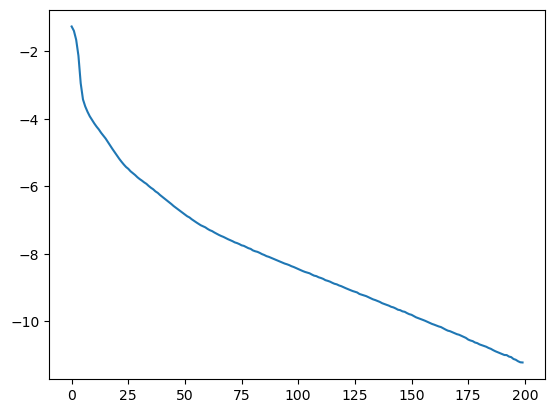

In [30]:
for epoch in tqdm(range(200)):
    los = []
    for broad, narrow, result in dataloader:
        result = result / 45000
        optimizer.zero_grad()
        output = model(broad, narrow)
        loss = criterion(output, result)
        los.append(loss.item())
        loss.backward()
        optimizer.step()
    losses.append(np.mean(los))
plt.plot(np.log(losses))

In [31]:
model(torch.ones(1, len(broad_words)), torch.ones(1, len(narrow_words))) * 45000

tensor([[77032.4062]], grad_fn=<MulBackward0>)

In [32]:
model(torch.ones(1, len(broad_words)) * -1, torch.ones(1, len(narrow_words)) * -1) * 45000

tensor([[0.]], grad_fn=<MulBackward0>)

In [33]:
torch.save(model.state_dict(), 'model1.pt')

In [38]:
script_model = torch.jit.script(model)
script_model

RecursiveScriptModule(
  original_name=Model
  (broad): RecursiveScriptModule(
    original_name=Sequential
    (0): RecursiveScriptModule(original_name=Linear)
    (1): RecursiveScriptModule(original_name=ReLU)
    (2): RecursiveScriptModule(original_name=Linear)
    (3): RecursiveScriptModule(original_name=ReLU)
  )
  (narrow): RecursiveScriptModule(
    original_name=Sequential
    (0): RecursiveScriptModule(original_name=Linear)
    (1): RecursiveScriptModule(original_name=ReLU)
    (2): RecursiveScriptModule(original_name=Linear)
    (3): RecursiveScriptModule(original_name=ReLU)
    (4): RecursiveScriptModule(original_name=Linear)
    (5): RecursiveScriptModule(original_name=ReLU)
    (6): RecursiveScriptModule(original_name=Linear)
  )
  (combined): RecursiveScriptModule(
    original_name=Sequential
    (0): RecursiveScriptModule(original_name=Linear)
    (1): RecursiveScriptModule(original_name=ReLU)
    (2): RecursiveScriptModule(original_name=Linear)
    (3): RecursiveScript

In [37]:
script_model.save('model1_script.pt')

In [43]:
broad_words_def = ""
for key in broad_words_toi.keys():
    broad_words_def += f"\"{key}\", "
broad_words_def

'"here", "beach", "stone", "skill", "best", "cantle", "valetudinarian", "bloat", "pastiche", "pittance", "twice", "clean", "shave", "verdure", "smart", "pay", "fish", "sapling", "ruthless", "raiment", "prig", "work", "near", "uxoricide", "deaf", "often", "twelve", "ballast", "shaggy", "after", "leitmotiv", "vibrissae", "hint", "imbroglio", "call", "thick", "bury", "box", "soul", "mammon", "discomfit", "flow", "dairy", "ferry", "svelte", "plank", "trundle", "streamline", "loot", "awry", "conflate", "respite", "white", "rescue", "dagger", "clever", "tomorrow", "stance", "tool", "while", "shake", "him", "cradle", "writhe", "cash", "maladroit", "wag", "legerdemain", "grumble", "rise", "corner", "sully", "gather", "ledge", "clap", "crowd", "midget", "sparge", "hope", "ask", "clay", "reproach", "bat", "hair", "opsimath", "pick", "ostrich", "mere", "mist", "pule", "hand", "throttle", "tureen", "ajar", "think", "go", "mawkish", "shrivel", "constraint", "moon", "soothsayer", "shovel", "gleam", 

In [44]:
narrow_words_def = ""
for key in narrow_words_toi.keys():
    narrow_words_def += f"\"{key}\", "
narrow_words_def

'"food", "either", "house", "best", "bell", "bloat", "invoice", "morning", "allow", "dirge", "love", "fuddle", "witness", "eye", "clean", "world", "verdure", "topple", "walk", "repartee", "hamper", "rampant", "fish", "sudden", "book", "change", "loud", "scent", "try", "puny", "lack", "car", "squelch", "vibrissae", "drive", "box", "bring", "happy", "discomfit", "lap", "rush", "ferry", "neat", "trade", "meet", "plank", "trundle", "harvest", "jump", "extol", "fall", "streamline", "awry", "cower", "win", "regnant", "tidings", "mouth", "sauce", "street", "seed", "sham", "respite", "dagger", "tatterdemalion", "blue", "many", "finish", "why", "match", "clever", "tool", "wriggle", "judicious", "spool", "burgeon", "young", "him", "steep", "writhe", "drip", "alley", "brush", "ready", "award", "portmanteau", "start", "brain", "sister", "beware", "cellar", "lawn", "pump", "rise", "corner", "wear", "gather", "melange", "health", "captious", "suffuse", "sparge", "wing", "reproach", "ask", "gate", "e